<a href="https://colab.research.google.com/github/ninja18/deeplearning-practice/blob/main/attentions/luong-attention/luong-dot-attention-de-en-translator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Luong Attention
Paper: [Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/pdf/1508.04025) - Luong et. al 2015

Dataset: [Multi30K English to Deutsche dataset](https://huggingface.co/datasets/bentrevett/multi30k)

Model: Use LSTM as encoder and decoder

### Variations
- Start with Dot product attention and place attention after decoder LSTM and train
- Use learnable projection attention and train
- Do input feeding and train

Skipped local attention since that is mainly for efficiency at this point

**This notebook only covers the pure dot product attention and placing the attention after the decoder**

In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
repo_cloned = False
try:
    import google.colab
    is_running_on_colab = True
except ImportError:
    is_running_on_colab = False

In [2]:
# colab specific
import os

if is_running_on_colab:
  %pip install early-stopping-pytorch torchmetrics

  if not repo_cloned:
    repo_cloned = True
    !git clone https://github.com/ninja18/deeplearning-practice.git
    os.chdir('deeplearning-practice/attentions/luong-attention')

  print(os.getcwd())

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 64.9 MB/s eta 0:00:00
Cloning into 'deeplearning-practice'...
remote: Enumerating objects: 347, done.
remote: Counting objects: 100% (347/347), done.
remote: Compressing objects: 100% (221/221), done.
remote: Total 347 (delta 133), reused 288 (delta 86), pack-reused 0 (from 0)
Receiving objects: 100% (347/347), 7.74 MiB | 17.05 MiB/s, done.
Resolving deltas: 100% (133/133), done.
/content/deeplearning-practice/attentions/luong-attention


In [3]:
import random
import numpy as np
import torch

SEED = 1557
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [4]:
from datasets import load_dataset
from torch.utils.data import DataLoader
from utils.multi30k_data_processing_utils import word_tokenize, build_vocab, preprocess, decode, collate_fn
from utils.multi30k_data_processing_utils import BOS, PAD, EOS

In [5]:
train_dataset = load_dataset("bentrevett/multi30k", split="train")
tokenized_train_dataset = train_dataset.map(lambda x: {"en": word_tokenize(x["en"]), "de": word_tokenize(x["de"])}, batched=False)

en_vocab_to_index, en_index_to_vocab = build_vocab(
    [item["en"] for item in tokenized_train_dataset]
)
de_vocab_to_index, de_index_to_vocab = build_vocab(
    [item["de"] for item in tokenized_train_dataset]
)

preprocessed_train_dataset = train_dataset.map(
    lambda x: preprocess(x, "de", "en", de_vocab_to_index, en_vocab_to_index),
    batched=True,
    remove_columns=["en", "de"]
)
preprocessed_train_dataset.set_format(type="torch", columns=["source", "target"])

print(preprocessed_train_dataset[0])
print(f"German: {decode(de_index_to_vocab, preprocessed_train_dataset[0]['source'].tolist())}")
print(f"English: {decode(en_index_to_vocab, preprocessed_train_dataset[0]['target'].tolist())}")

loader = DataLoader(
    preprocessed_train_dataset,
    batch_size=3,
    shuffle=True,
    collate_fn=collate_fn,
)

batch = next(iter(loader))
print(batch["source"].shape)
print(batch["source_lengths"].shape)
print(batch["target"].shape)
print(batch["target_lengths"].shape)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train.jsonl: 0.00B [00:00, ?B/s]

val.jsonl: 0.00B [00:00, ?B/s]

test.jsonl: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/29000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1014 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/29000 [00:00<?, ? examples/s]

Map:   0%|          | 0/29000 [00:00<?, ? examples/s]

{'source': tensor([   1,   18,   27,  215,   31,   85,   20,   89,    7,   15,  115,    3,
        3149,    4,    2]), 'target': tensor([   1,   16,   24,   15,   25,  776,   17,   57,   80,  204, 1305,    5,
           2])}
German: zwei junge weiße männer sind im freien in der nähe <unk> büsche .
English: two young , white males are outside near many bushes .
torch.Size([3, 15])
torch.Size([3])
torch.Size([3, 16])
torch.Size([3])


In [6]:
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout, device, padding_idx=0):
        super().__init__()
        self.device = device
        self.directions = 2
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)
        self.dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, dropout=dropout if num_layers > 1 else 0.0, batch_first=True, bidirectional=True)
        self.hidden_projection = nn.Linear(2 * hidden_dim, hidden_dim)
        self.cell_projection = nn.Linear(2 * hidden_dim, hidden_dim)

    def forward(self, source_encodings, source_lengths): # source_encodings: (batch_size, max_length), source_lengths: (batch_size)
        B, T = source_encodings.size()
        h_0 = torch.zeros(self.num_layers * self.directions, B, self.hidden_dim, device=self.device)
        c_0 = torch.zeros(self.num_layers * self.directions, B, self.hidden_dim, device=self.device)

        embedded = self.embedding(source_encodings) # (B, T, embedding_dim)
        embedded = self.dropout(embedded)

        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, source_lengths.to('cpu'), batch_first=True, enforce_sorted=False)
        packed_outputs, (last_hidden, last_cell) = self.lstm(packed_embedded, (h_0, c_0)) # hidden: (num_layers * directions, B, hidden_dim)
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs, batch_first=True) # outputs: (B, T, hidden_dim * directions)

        h_f = last_hidden[0::2] # (num_layers, B, hidden_dim)
        h_b = last_hidden[1::2] # (num_layers, B, hidden_dim)
        h_cat = torch.cat((h_f, h_b), dim=2) # (num_layers, B, hidden_dim * 2) concatenate along the hidden dimension

        c_f = last_cell[0::2] # (num_layers, B, hidden_dim)
        c_b = last_cell[1::2] # (num_layers, B, hidden_dim)
        c_cat = torch.cat((c_f, c_b), dim=2) # (num_layers, B, hidden_dim * 2) concatenate along the hidden dimension


        # returning concatenated hidden and cell states because dot product attention needs both encoder and decoder states to be of same shape
        # decoder size is increased to (num_layers, B, hidden_dim * 2)
        return outputs, h_cat, c_cat


In [ ]:
from torch.nn import functional as F

class DotProductAttention(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, decoder_hidden_states, encoder_outputs, mask): # decoder_hidden_states: (num_layers, B, 2 * hidden_dim), encoder_outputs: (B, T, 2 * hidden_dim) bidirectional LSTM
        # use the last hidden state of the multi-layer LSTM decoder as the query

        query = decoder_hidden_states[-1] # (B, 2 * hidden_dim)

        # change to column vector
        query = query.unsqueeze(2) # (B, 2 * hidden_dim, 1)

        # encoder_outputs @ query and the other produce same result
        energy = encoder_outputs @ query # (B, T, 1)
        energy = energy.squeeze(2) # (B, T)

        # prevent the attention to the padding tokens and -1e9 is a large negative number.
        # don't use 0 because e^0 = 1
        # don't use -inf because it will cause the softmax to return NaN
        # -1e9 is suitable for float32. For float16, -1e4 is more suitable.
        energy = energy.masked_fill(mask, -1e9)
        attention_weights = F.softmax(energy, dim=1) # (B, T)

        return attention_weights

In [7]:
class LuongAttentionDecoder(nn.Module):
    """
    Decoder for the Seq2Seq model. This works on a batch of single step targets (B, 1).
    It doesn't take the entire target sequence, because the decision to teacher force and what kind of search strategy to use
    is done at the sequence level, not the step level.
    """
    def __init__(self, attention, vocab_size, embedding_dim, hidden_dim, num_layers, dropout, padding_idx=0):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)
        self.dropout = nn.Dropout(dropout)
        self.attention = attention
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
            batch_first=True,
            bidirectional=False,
        )
        self.attention_projection = nn.Linear(2*hidden_dim, hidden_dim)
        self.output_projection = nn.Linear(hidden_dim, vocab_size)

    def forward(self, inputs, last_hidden, last_cell, encoder_outputs, mask):
        # Note: (B, 1) is needed because the LSTM expects a 2D input (batch_size, sequence_length)
        inputs = inputs.unsqueeze(1) # (B, 1)

        embedded = self.embedding(inputs)  # (B, 1, embedding_dim)
        embedded = self.dropout(embedded)

        outputs, (hidden, cell) = self.lstm(embedded, (last_hidden, last_cell)) # (B, 1, hidden_dim), (num_layers, B, hidden_dim)

        attention_weights = self.attention(hidden, encoder_outputs, mask) # (B, T)
        attention_weights = attention_weights.unsqueeze(1) # (B, 1, T)
        context_vector = attention_weights @ encoder_outputs # (B, 1, hidden_dim)

        prediction_input = torch.cat((context_vector, outputs), dim=2) # (B, 1, hidden_dim + hidden_dim)

        prediction_input = self.dropout(prediction_input)
        prediction_output = torch.tanh(self.attention_projection(prediction_input))
        logits = self.output_projection(prediction_output) # (B, 1, vocab_size)

        return logits, hidden, cell, attention_weights.squeeze(1)

In [ ]:
test_encoder = Encoder(len(de_vocab_to_index), 256, 256, 2, 0.0, 'cpu')
test_attention = DotProductAttention()
test_decoder = LuongAttentionDecoder(test_attention, len(en_vocab_to_index), 256, 2 * 256, 2, 0.0, de_vocab_to_index[BOS])

batch_mask = batch["source"] == de_vocab_to_index[PAD]

encoder_outputs, hidden, cell = test_encoder.forward(batch["source"], batch["source_lengths"])

logits, hidden, cell, attention_weights = test_decoder.forward(batch["target"][:, 0], hidden, cell, encoder_outputs, batch_mask)

print(f"target: {batch['target'][:, 0]}")
print(f"Logits: {logits.shape}")
print(f"Hidden: {hidden.shape}")
print(f"Cell: {cell.shape}")
print(f"Attention weights: {attention_weights.shape}")

print(f"Attention weights: {attention_weights}")

target: tensor([1, 1, 1])
Logits: torch.Size([3, 1, 4560])
Hidden: torch.Size([2, 3, 512])
Cell: torch.Size([2, 3, 512])
Attention weights: torch.Size([3, 15])
Attention weights: tensor([[0.0726, 0.0702, 0.0691, 0.0675, 0.0677, 0.0661, 0.0654, 0.0651, 0.0647,
         0.0654, 0.0628, 0.0624, 0.0644, 0.0677, 0.0690],
        [0.1478, 0.1447, 0.1401, 0.1377, 0.1405, 0.1444, 0.1447, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0760, 0.0741, 0.0727, 0.0704, 0.0682, 0.0687, 0.0701, 0.0694, 0.0692,
         0.0697, 0.0699, 0.0710, 0.0749, 0.0759, 0.0000]],
       grad_fn=<SqueezeBackward1>)


In [9]:
class AttentionSeq2Seq(nn.Module):
    def __init__(self, encoder, decoder, bos_idx, eos_idx, padding_idx, max_target_length, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.bos_idx = bos_idx
        self.eos_idx = eos_idx
        self.padding_idx = padding_idx
        self.max_target_length = max_target_length
        self.device = device

    def forward(self, source, source_lengths, target, teacher_forcing_ratio=0.5):
        B = source.shape[0]
        # Target shape: (B, T) including <bos> and <eos>
        # We process T-1 steps (predicting from <bos> up to second-to-last token)
        target_len = target.shape[1] - 1

        mask = self._create_attention_mask(source)
        encoder_outputs, hidden, cell = self.encoder(source, source_lengths)

        inputs = target[:, 0]
        outputs = torch.zeros(B, target_len, self.decoder.vocab_size, device=self.device)

        for t in range(0, target_len):
            logits, hidden, cell, _ = self.decoder(inputs, hidden, cell, encoder_outputs, mask)
            logits = logits.squeeze(1) # (B, 1, vocab_size) -> (B, vocab_size)
            outputs[:, t] = logits

            top1 = logits.argmax(dim=1)

            teacher_force = random.random() < teacher_forcing_ratio
            inputs = target[:, t + 1] if teacher_force else top1

        return outputs

    @torch.no_grad()
    def generate(self, source, source_lengths, topk=0):
        """
        Inference pass for generating translations.
        Returns predicted indices.
        """
        B = source.shape[0]

        mask = self._create_attention_mask(source)
        encoder_outputs, hidden, cell = self.encoder(source, source_lengths)

        inputs = torch.full((B,), self.bos_idx, dtype=torch.long, device=self.device)
        preds_all = [] # using list instead of tensor due to its variable length
        attention_weights_all = []

        for _ in range(self.max_target_length):
            logits, hidden, cell, attention_weights = self.decoder(inputs, hidden, cell, encoder_outputs, mask)
            step_logits = logits.squeeze(1) # (B, 1, vocab_size) -> (B, vocab_size)

            if topk > 0:
                step_preds = self._topk_decode(step_logits, topk)
            else:
                step_preds = step_logits.argmax(dim=1)

            preds_all.append(step_preds.unsqueeze(1))
            attention_weights_all.append(attention_weights)
            inputs = step_preds

            if step_preds.eq(self.eos_idx).all():
                break

        return torch.cat(preds_all, dim=1), torch.stack(attention_weights_all, dim=1)

    def _create_attention_mask(self, source):
        return source == self.padding_idx

    def _topk_decode(self, logits, topk):
        step_logits = logits.squeeze(1) # (B, vocab_size)

        topk_logits, topk_vocab_ids = torch.topk(step_logits, topk, dim=-1) # (B, k)
        topk_probs = torch.softmax(topk_logits, dim=-1) # (B, k)

        sample_pos = torch.multinomial(topk_probs, num_samples=1) # (B, 1)
        preds = topk_vocab_ids.gather(1, sample_pos) # (B, 1)
        return preds.squeeze(1)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [11]:
tgt_vocab_size = len(en_vocab_to_index) # 4560
src_vocab_size = len(de_vocab_to_index) # 5422
emb_dim = 512
hidden_dim = 512
dec_hidden_dim = 2 * hidden_dim
enc_num_layers = 2
dec_num_layers = 2
enc_dropout = 0.3
dec_dropout = 0.3
padding_idx = de_vocab_to_index[PAD]
bos_idx = de_vocab_to_index[BOS]
eos_idx = de_vocab_to_index[EOS]
max_target_length = 25

batch_size = 128
learning_rate = 0.0005
epochs = 40
max_grad_norm = 1.0
topk = 5
early_stopping_patience = 7
teacher_forcing_decay_constant = epochs / 6

In [12]:
from utils.train_utils import inverse_sigmoid_decay

for e in range(epochs):
    teacher_forcing_ratio = inverse_sigmoid_decay(e, k=teacher_forcing_decay_constant)
    print(f"epoch: {e} Teacher forcing ratio: {teacher_forcing_ratio}")

epoch: 0 Teacher forcing ratio: 0.87
epoch: 1 Teacher forcing ratio: 0.85
epoch: 2 Teacher forcing ratio: 0.83
epoch: 3 Teacher forcing ratio: 0.81
epoch: 4 Teacher forcing ratio: 0.79
epoch: 5 Teacher forcing ratio: 0.76
epoch: 6 Teacher forcing ratio: 0.73
epoch: 7 Teacher forcing ratio: 0.7
epoch: 8 Teacher forcing ratio: 0.67
epoch: 9 Teacher forcing ratio: 0.63
epoch: 10 Teacher forcing ratio: 0.6
epoch: 11 Teacher forcing ratio: 0.56
epoch: 12 Teacher forcing ratio: 0.52
epoch: 13 Teacher forcing ratio: 0.49
epoch: 14 Teacher forcing ratio: 0.45
epoch: 15 Teacher forcing ratio: 0.41
epoch: 16 Teacher forcing ratio: 0.38
epoch: 17 Teacher forcing ratio: 0.34
epoch: 18 Teacher forcing ratio: 0.31
epoch: 19 Teacher forcing ratio: 0.28
epoch: 20 Teacher forcing ratio: 0.25
epoch: 21 Teacher forcing ratio: 0.22
epoch: 22 Teacher forcing ratio: 0.2
epoch: 23 Teacher forcing ratio: 0.17
epoch: 24 Teacher forcing ratio: 0.15
epoch: 25 Teacher forcing ratio: 0.14
epoch: 26 Teacher forcing

In [ ]:
encoder = Encoder(src_vocab_size, emb_dim, hidden_dim, enc_num_layers, enc_dropout, device, padding_idx)
additive_attention = DotProductAttention()
decoder = LuongAttentionDecoder(additive_attention, tgt_vocab_size, emb_dim, dec_hidden_dim, dec_num_layers, dec_dropout, padding_idx)

model = AttentionSeq2Seq(encoder, decoder, bos_idx, eos_idx, padding_idx, max_target_length, device)
model.to(device)

AttentionSeq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(5422, 512, padding_idx=0)
    (dropout): Dropout(p=0.3, inplace=False)
    (lstm): LSTM(512, 512, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
    (hidden_projection): Linear(in_features=1024, out_features=512, bias=True)
    (cell_projection): Linear(in_features=1024, out_features=512, bias=True)
  )
  (decoder): LuongAttentionDecoder(
    (embedding): Embedding(4560, 512, padding_idx=0)
    (dropout): Dropout(p=0.3, inplace=False)
    (attention): DotProductAttention()
    (lstm): LSTM(512, 1024, num_layers=2, batch_first=True, dropout=0.3)
    (attention_projection): Linear(in_features=2048, out_features=1024, bias=True)
    (output_projection): Linear(in_features=1024, out_features=4560, bias=True)
  )
)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The Seq2Seq model has {count_parameters(model):,} trainable parameters')
print(f"Encoder parameters: {count_parameters(encoder):,}")
print(f"Decoder parameters: {count_parameters(decoder):,}")
print(f"Attention parameters: {count_parameters(additive_attention):,}")

The Seq2Seq model has 38,131,152 trainable parameters
Encoder parameters: 14,327,808
Decoder parameters: 23,803,344
Attention parameters: 0


In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=de_vocab_to_index[PAD]).to(device)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [13]:
from utils.train_utils import train, validate_with_bleu_score, validate_with_teacher_forcing
from utils.multi30k_data_processing_utils import collate_fn

train_dataset = load_dataset("bentrevett/multi30k", split="train")
val_dataset = load_dataset("bentrevett/multi30k", split="validation")

final_train_dataset = train_dataset.map(
    lambda x: preprocess(x, "de", "en", de_vocab_to_index, en_vocab_to_index),
    batched=True,
    remove_columns=["en", "de"]
)
final_train_dataset.set_format(type="torch", columns=["source", "target"])

final_val_dataset = val_dataset.map(
    lambda x: preprocess(x, "de", "en", de_vocab_to_index, en_vocab_to_index),
    batched=True,
    remove_columns=["en", "de"]
)
final_val_dataset.set_format(type="torch", columns=["source", "target"])

pin_memory = True if device == "cuda" else False

train_loader = DataLoader(final_train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=2, pin_memory=pin_memory, persistent_workers=True)
val_loader = DataLoader(final_val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=2, pin_memory=pin_memory, persistent_workers=True)

Map:   0%|          | 0/1014 [00:00<?, ? examples/s]

In [14]:
import time
from early_stopping_pytorch import EarlyStopping
from utils.train_utils import epoch_time, inverse_sigmoid_decay

def train_loop(model, train_loader, val_loader, criterion, optimizer, epochs, model_path, patience=3):
    early_stopping = EarlyStopping(patience=patience, verbose=True, path=model_path)
    train_losses = []
    val_losses = []
    val_bleu_scores = []
    teacher_forcing_ratios = []

    for e in range(epochs):
        start_time = time.time()
        teacher_forcing_ratio = inverse_sigmoid_decay(e, k=teacher_forcing_decay_constant)

        train_loss = train(model, train_loader, criterion, optimizer, max_grad_norm, teacher_forcing_ratio, device)
        val_loss = validate_with_teacher_forcing(model, val_loader, criterion, device)
        val_bleu = validate_with_bleu_score(model, val_loader, en_index_to_vocab, device)

        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_bleu_scores.append(val_bleu)
        teacher_forcing_ratios.append(teacher_forcing_ratio)

        print(f"Epoch {e+1}: Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}, Val BLEU: {val_bleu:.4f}, Teacher forcing ratio: {teacher_forcing_ratio:.4f}, Epoch time: {epoch_mins}m {epoch_secs}s")

        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
    return train_losses, val_losses, val_bleu_scores, teacher_forcing_ratios

In [15]:
if is_running_on_colab:
    from google.colab import drive
    drive.mount('/content/drive')

    model_location = '/content/drive/My Drive/ML study/Attentions/luong attention/weights'
    artifacts_location = '/content/drive/My Drive/ML study/Attentions/luong attention/artifacts'
else:
    model_location = 'weights'
    artifacts_location = 'artifacts'

training_prefix = 'luong-dot-attention-model'
model_path = f'{model_location}/{training_prefix}.pt'
artifacts_path = f'{artifacts_location}/{training_prefix}-artifacts.json'
loss_graph_path = f'{artifacts_location}/{training_prefix}-loss-graph.png'

Mounted at /content/drive


In [ ]:
train_losses, val_losses, val_bleu_scores, teacher_forcing_ratios = train_loop(model, train_loader, val_loader, criterion, optimizer, epochs, model_path, patience=early_stopping_patience)

Epoch 1: Train loss: 4.4321, Val loss: 3.3902, Val BLEU: 0.0825, Teacher forcing ratio: 0.8700, Epoch time: 1m 6s
Validation loss decreased (inf --> 3.390245).  Saving model ...
Epoch 2: Train loss: 3.3572, Val loss: 2.7922, Val BLEU: 0.1415, Teacher forcing ratio: 0.8500, Epoch time: 1m 7s
Validation loss decreased (3.390245 --> 2.792187).  Saving model ...
Epoch 3: Train loss: 2.9161, Val loss: 2.4832, Val BLEU: 0.1820, Teacher forcing ratio: 0.8300, Epoch time: 1m 8s
Validation loss decreased (2.792187 --> 2.483177).  Saving model ...
Epoch 4: Train loss: 2.6127, Val loss: 2.2947, Val BLEU: 0.2071, Teacher forcing ratio: 0.8100, Epoch time: 1m 7s
Validation loss decreased (2.483177 --> 2.294737).  Saving model ...
Epoch 5: Train loss: 2.3816, Val loss: 2.1718, Val BLEU: 0.2315, Teacher forcing ratio: 0.7900, Epoch time: 1m 7s
Validation loss decreased (2.294737 --> 2.171848).  Saving model ...
Epoch 6: Train loss: 2.2122, Val loss: 2.0619, Val BLEU: 0.2505, Teacher forcing ratio: 0.

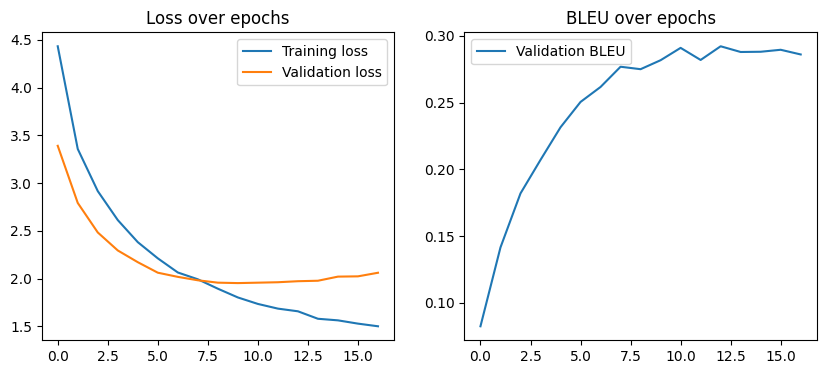

In [ ]:
from utils.train_utils import save_artifacts, show_graph

save_artifacts(model, train_losses, val_losses, val_bleu_scores, teacher_forcing_ratios, batch_size, learning_rate, epochs, artifacts_path, model_path, max_grad_norm)
show_graph(train_losses, val_losses, val_bleu_scores, save_path=loss_graph_path, save=True)

In [ ]:
from utils.train_utils import load_model
load_model(model, model_path, device)

AttentionSeq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(5422, 512, padding_idx=0)
    (dropout): Dropout(p=0.3, inplace=False)
    (lstm): LSTM(512, 512, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
    (hidden_projection): Linear(in_features=1024, out_features=512, bias=True)
    (cell_projection): Linear(in_features=1024, out_features=512, bias=True)
  )
  (decoder): LuongAttentionDecoder(
    (embedding): Embedding(4560, 512, padding_idx=0)
    (dropout): Dropout(p=0.3, inplace=False)
    (attention): DotProductAttention()
    (lstm): LSTM(512, 1024, num_layers=2, batch_first=True, dropout=0.3)
    (attention_projection): Linear(in_features=2048, out_features=1024, bias=True)
    (output_projection): Linear(in_features=1024, out_features=4560, bias=True)
  )
)

In [ ]:
test_dataset = load_dataset("bentrevett/multi30k", split="test")
test_dataset = test_dataset.map(
    lambda x: preprocess(x, "de", "en", de_vocab_to_index, en_vocab_to_index),
    batched=True,
    remove_columns=["en", "de"]
)
test_dataset.set_format(type="torch", columns=["source", "target"])

test_loader = DataLoader(test_dataset, batch_size=5, shuffle=True, collate_fn=collate_fn)

In [ ]:
from utils.train_utils import translate

test_batch = next(iter(test_loader))
translation_results = translate(model, test_batch, de_index_to_vocab, en_index_to_vocab, topk, device)

Source: <bos> der junge im schwarzen t - shirt und blauen jeans hält einen roten baseballschläger .
Pred: the boy in the blue t - shirt and blue jeans , is holding up a red bat .
Target: <bos> the boy wearing a black shirt and blue jeans is holding a red baseball bat .
----------------------------------------------------------------------------------------------------
Source: <bos> ein kleines afrikanisches kind trägt ein jüngeres kind auf dem rücken .
Pred: a small child with child child is on a sidewalk with his arm .
Target: <bos> a small african child carries a younger child on his back .
----------------------------------------------------------------------------------------------------
Source: <bos> drei frauen in leuchtenden farben und mit kopfbedeckungen halten karten mit <unk> .
Pred: three woman with colorful clothes and colorful faces sticks holding sticks .
Target: <bos> three women in bright colors and <unk> are holding love message cards .
--------------------------------

Source: <bos> der junge im schwarzen t - shirt und blauen jeans hält einen roten baseballschläger .
Pred: the boy in the blue t - shirt and blue jeans , is holding up a red bat .
Target: <bos> the boy wearing a black shirt and blue jeans is holding a red baseball bat .
Attention weights: tensor([[1.3158e-07, 1.0000e+00, 1.9811e-06, 3.6388e-07, 2.1792e-07, 2.7966e-10,
         2.5926e-11, 7.1610e-14, 1.5460e-15, 6.8754e-14, 1.2793e-17, 2.5442e-22,
         1.1740e-20, 5.8313e-17, 1.6634e-17, 7.7780e-16],
        [2.5633e-10, 5.6244e-09, 4.4321e-09, 2.4152e-07, 3.5616e-06, 8.5043e-06,
         6.0467e-05, 2.1610e-07, 6.1328e-09, 2.6318e-06, 1.3307e-08, 2.7280e-10,
         1.8497e-08, 2.2078e-02, 4.9621e-01, 2.6260e-01],
        [6.1780e-10, 6.9447e-09, 2.1151e-10, 4.1173e-09, 1.6428e-06, 1.2575e-06,
         2.0485e-06, 6.0085e-08, 2.3516e-07, 1.8105e-04, 1.9455e-05, 3.4461e-07,
         1.3129e-06, 5.1641e-02, 5.2272e-01, 4.1870e-01],
        [2.7055e-06, 4.8127e-04, 1.8843e-06, 5.1023

/content/deeplearning-practice/attentions/luong-attention/utils/train_utils.py:183: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([""] + sentence, rotation=90)
/content/deeplearning-practice/attentions/luong-attention/utils/train_utils.py:184: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([""] + translation)


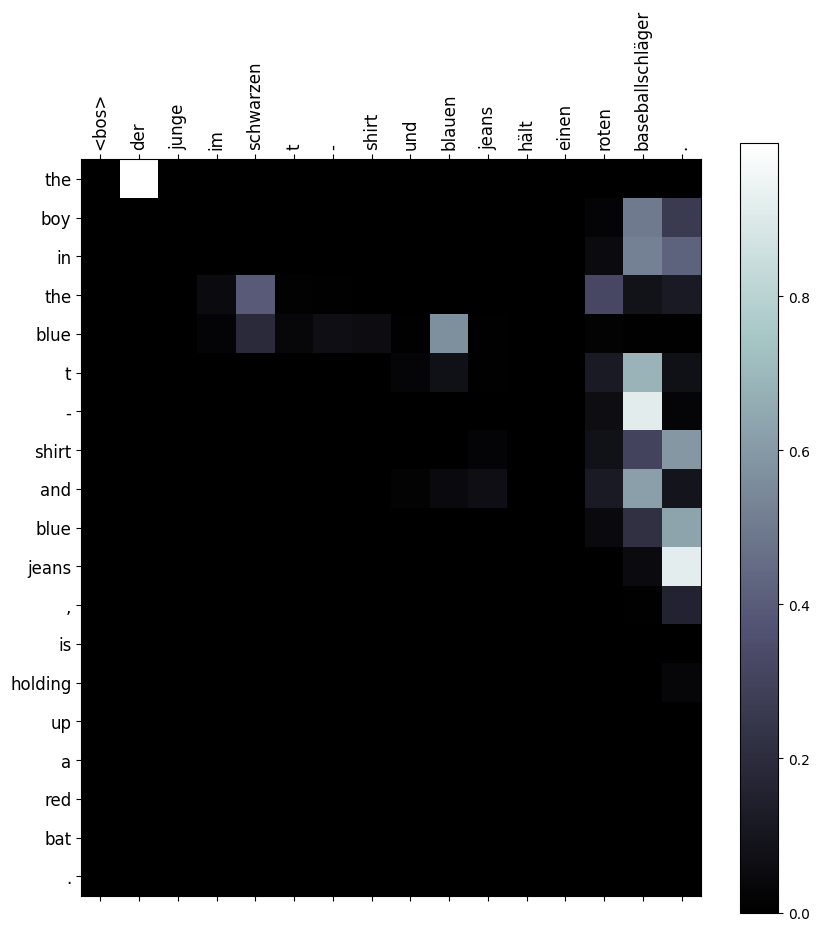

In [ ]:
from utils.train_utils import display_attention

one_translation = translation_results[0]
print(f"Source: {" ".join(one_translation['source'])}")
print(f"Pred: {" ".join(one_translation['prediction'])}")
print(f"Target: {" ".join(one_translation['target'])}")

print(f"Attention weights: {one_translation['attention_weights'][:len(one_translation['prediction']), :len(one_translation['source'])]}")

display_attention(one_translation['source'], one_translation['prediction'], one_translation['attention_weights'][:len(one_translation['prediction']), :len(one_translation['source'])])

Source: <bos> zwei <unk> <unk> <unk> in roten kleidern .
Pred: two native women are in <unk> red <unk> .
Target: <bos> two bald drag <unk> in red dresses


/content/deeplearning-practice/attentions/luong-attention/utils/train_utils.py:183: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([""] + sentence, rotation=90)
/content/deeplearning-practice/attentions/luong-attention/utils/train_utils.py:184: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([""] + translation)


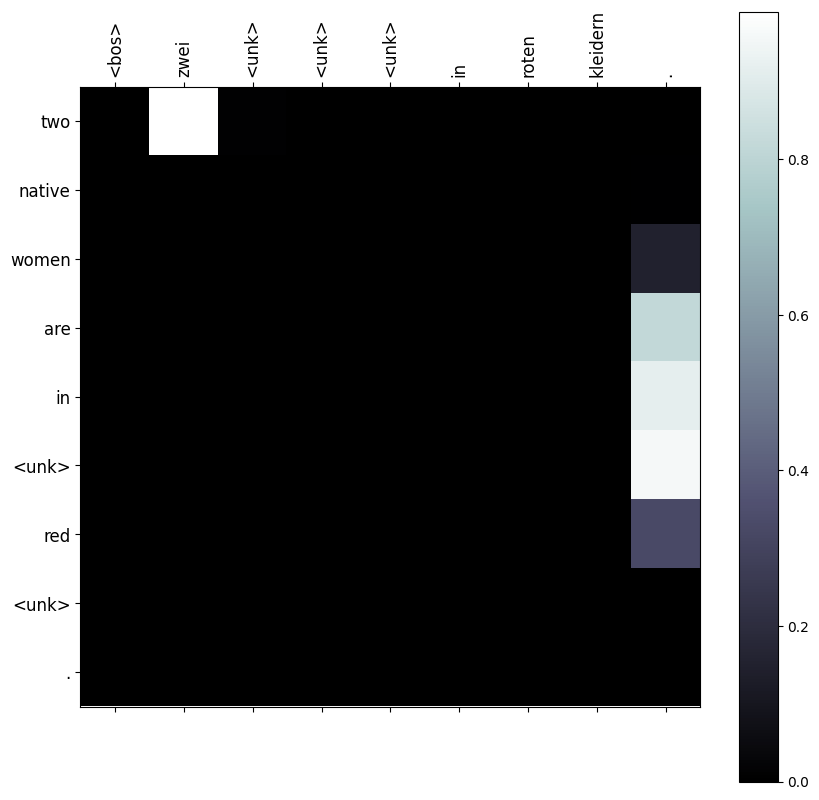

In [ ]:
another_translation = translation_results[4]
print(f"Source: {" ".join(another_translation['source'])}")
print(f"Pred: {" ".join(another_translation['prediction']).strip()}")
print(f"Target: {" ".join(another_translation['target']).strip()}")


display_attention(another_translation['source'], another_translation['prediction'], another_translation['attention_weights'][:len(another_translation['prediction']), :len(another_translation['source'])])

Source: <bos> mehrere männer in orange versammeln sich im freien für ein <unk> ereignis .
Pred: several men in formal attire gather outside for a fire ' s <unk> .
Target: <bos> several men dressed in orange gather for an outdoor social event .


/content/deeplearning-practice/attentions/luong-attention/utils/train_utils.py:183: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([""] + sentence, rotation=90)
/content/deeplearning-practice/attentions/luong-attention/utils/train_utils.py:184: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([""] + translation)


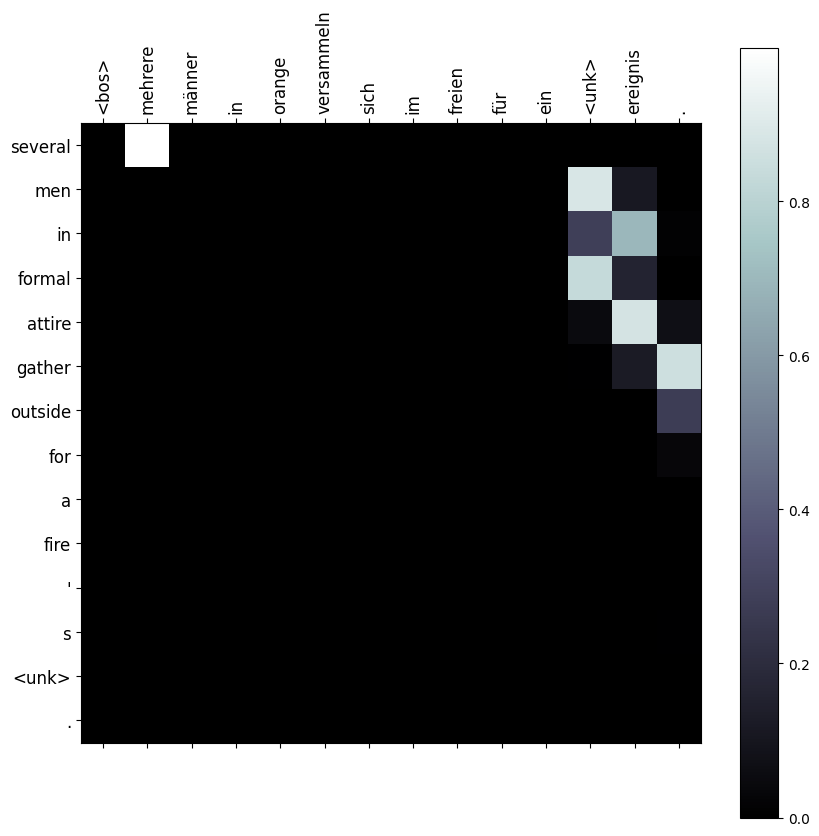

In [ ]:
another_translation = translation_results[3]
print(f"Source: {" ".join(another_translation['source'])}")
print(f"Pred: {" ".join(another_translation['prediction']).strip()}")
print(f"Target: {" ".join(another_translation['target']).strip()}")


display_attention(another_translation['source'], another_translation['prediction'], another_translation['attention_weights'][:len(another_translation['prediction']), :len(another_translation['source'])])

In [ ]:
test_dataset = load_dataset("bentrevett/multi30k", split="test")
test_dataset = test_dataset.map(
    lambda x: preprocess(x, "de", "en", de_vocab_to_index, en_vocab_to_index),
    batched=True,
    remove_columns=["en", "de"]
)
test_dataset.set_format(type="torch", columns=["source", "target"])

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

test_bleu_score = validate_with_bleu_score(model, test_loader, en_index_to_vocab, device)

print(f"Test BLEU Score: {test_bleu_score*100:.2f}")

Test BLEU Score: 28.90


### Analysis of Dot Product attention model
From the attention weight visualization notice that the weights are collapsing to the boundaries(last 2 tokens) of the sequence. This could be due the nature of dot product.
Dot product gives higher values for **higher magnitude** and better **cosine similarity**.
Since the boundary hidden states summarize the whole input sequence and are information dense, they tend to have higher norm and align with the decoder state better.

To test this idea let's print the norms of both decoder and encoder states for each time step.

In [ ]:
from torch.nn import functional as F


class DebugDotProductAttention(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(
        self, decoder_hidden_states, encoder_outputs, mask
    ):  # decoder_hidden_states: (num_layers, B, 2 * hidden_dim), encoder_outputs: (B, T, 2 * hidden_dim) bidirectional LSTM
        query = decoder_hidden_states[-1]  # (B, 2 * hidden_dim)
        query = query.unsqueeze(2)  # (B, 2 * hidden_dim, 1)
        energy = encoder_outputs @ query  # (B, T, 1)
        energy = energy.squeeze(2)  # (B, T)

        energy = energy.masked_fill(mask, -1e9)
        attention_weights = F.softmax(energy, dim=1)  # (B, T)

        query = query.squeeze(2)

        print(f"Query norm: {torch.linalg.vector_norm(query, dim=1)}, mean: {query.mean(dim=1)}, std: {query.std(dim=1)}")

        print(f"Cosine similarity: {F.cosine_similarity(query.unsqueeze(1), encoder_outputs, dim=-1)}")

        return attention_weights

In [ ]:
from utils.train_utils import load_model

debug_encoder = Encoder(src_vocab_size, emb_dim, hidden_dim, enc_num_layers, enc_dropout, device, padding_idx)
debug_dot_product_attention = DebugDotProductAttention()
debug_decoder = LuongAttentionDecoder(debug_dot_product_attention, tgt_vocab_size, emb_dim, dec_hidden_dim, dec_num_layers, dec_dropout, padding_idx)

debug_model = AttentionSeq2Seq(debug_encoder, debug_decoder, bos_idx, eos_idx, padding_idx, max_target_length, device)
debug_model.to(device)

load_model(debug_model, model_path, device)

AttentionSeq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(5422, 512, padding_idx=0)
    (dropout): Dropout(p=0.3, inplace=False)
    (lstm): LSTM(512, 512, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
    (hidden_projection): Linear(in_features=1024, out_features=512, bias=True)
    (cell_projection): Linear(in_features=1024, out_features=512, bias=True)
  )
  (decoder): LuongAttentionDecoder(
    (embedding): Embedding(4560, 512, padding_idx=0)
    (dropout): Dropout(p=0.3, inplace=False)
    (attention): DebugDotProductAttention()
    (lstm): LSTM(512, 1024, num_layers=2, batch_first=True, dropout=0.3)
    (attention_projection): Linear(in_features=2048, out_features=1024, bias=True)
    (output_projection): Linear(in_features=1024, out_features=4560, bias=True)
  )
)

In [ ]:
from utils.train_utils import translate
from utils.train_utils import display_attention

debug_test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

Encoder outputs norm: tensor([[11.7037, 13.6820, 11.0823, 10.1398,  9.2786,  9.5939, 10.1367, 10.1044,
          9.9197, 10.3960, 12.0343, 14.5581]]), mean: tensor([[ 0.0025,  0.0170,  0.0199,  0.0197,  0.0099,  0.0114,  0.0053,  0.0032,
          0.0003,  0.0034,  0.0021, -0.0066]]), std: tensor([[0.3659, 0.4274, 0.3459, 0.3164, 0.2899, 0.2997, 0.3169, 0.3159, 0.3101,
         0.3250, 0.3762, 0.4551]])
Query norm: tensor([14.1765]), mean: tensor([0.0037]), std: tensor([0.4432])
Cosine similarity: tensor([[0.2834, 0.3601, 0.3549, 0.3104, 0.2448, 0.2087, 0.2707, 0.2570, 0.3060,
         0.2800, 0.1958, 0.1721]])
Query norm: tensor([16.1931]), mean: tensor([0.0195]), std: tensor([0.5059])
Cosine similarity: tensor([[-0.0468,  0.0203,  0.0908,  0.0812,  0.0698,  0.0276,  0.1362,  0.1457,
          0.2266,  0.2696,  0.2029,  0.1136]])
Query norm: tensor([13.1862]), mean: tensor([0.0176]), std: tensor([0.4119])
Cosine similarity: tensor([[-0.0691, -0.0210,  0.0722,  0.0941,  0.0798,  0.0056

/Users/niranjan/Documents/programming/AI/deeplearning/projects/deeplearning-practice/attentions/luong-attention/utils/train_utils.py:183: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([""] + sentence, rotation=90)
/Users/niranjan/Documents/programming/AI/deeplearning/projects/deeplearning-practice/attentions/luong-attention/utils/train_utils.py:184: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([""] + translation)


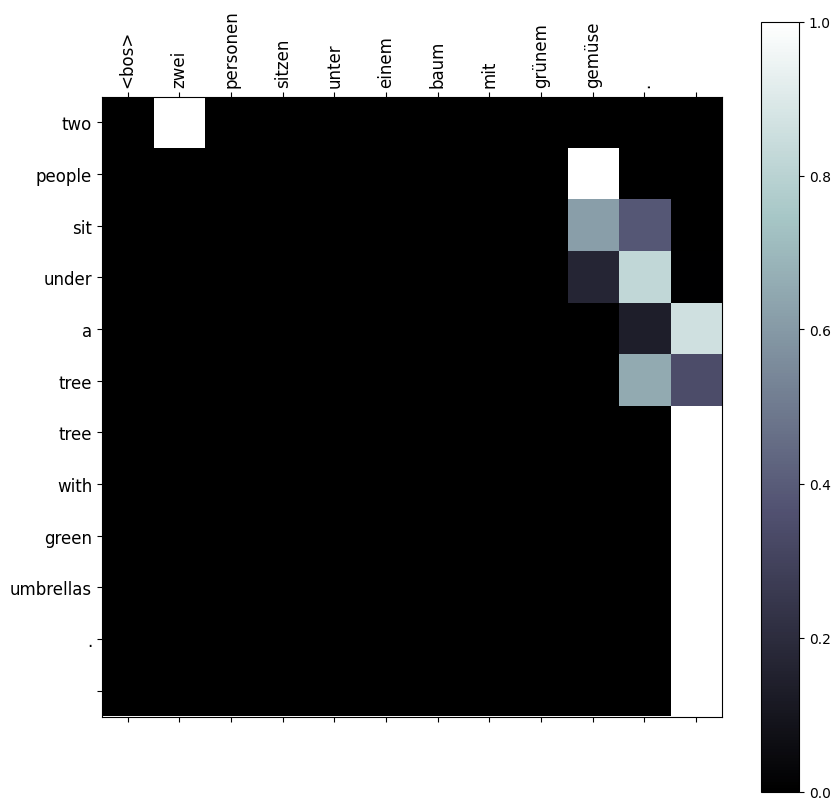

In [ ]:
test_batch = next(iter(debug_test_loader))
translation_results = translate(debug_model, test_batch, de_index_to_vocab, en_index_to_vocab, topk, device)

one_translation = translation_results[0]
print(f"Source: {" ".join(one_translation['source'])}")
print(f"Pred: {" ".join(one_translation['prediction'])}")
print(f"Target: {" ".join(one_translation['target'])}")

display_attention(one_translation['source'], one_translation['prediction'], one_translation['attention_weights'])

From the values the norm slightly higher at the 2nd index and the last two indices but the cosine similarity is consistently higher for last few indices.
This could be due to the fact that the decoder is initialized with last encoder state so they are both similar.

Also unlike Bahdanau, The context vector is not feed in to the recurrence from the previous step, so there's no impact of attention for the subsequent decoder states.

At this point, Decoder is just using the encoder as a sentence embedding without much use for attention.


#### Next steps
- Add scaling factor for dot product
- Do input feeding which will affect the decoder's subsequent states and avoid attending to same token every time.
- Do these individually and note the observations.

In [16]:
from torch.nn import functional as F

class ScaledDotProductAttention(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(
        self, decoder_hidden_states, encoder_outputs, mask
    ):  # decoder_hidden_states: (num_layers, B, 2 * hidden_dim), encoder_outputs: (B, T, 2 * hidden_dim) bidirectional LSTM
        query = decoder_hidden_states[-1]  # (B, 2 * hidden_dim)
        query = query.unsqueeze(2)  # (B, 2 * hidden_dim, 1)

        energy = encoder_outputs @ query  # (B, T, 1)
        energy = energy.squeeze(2)  # (B, T)

        scale = 1.0 / (encoder_outputs.size(-1) ** 0.5)
        energy = energy * scale

        energy = energy.masked_fill(mask, -1e9)
        attention_weights = F.softmax(energy, dim=1)  # (B, T)

        return attention_weights

In [17]:
scaled_encoder = Encoder(src_vocab_size, emb_dim, hidden_dim, enc_num_layers, enc_dropout, device, padding_idx)
scaled_dot_product_attention = ScaledDotProductAttention()
scaled_decoder = LuongAttentionDecoder(scaled_dot_product_attention, tgt_vocab_size, emb_dim, dec_hidden_dim, dec_num_layers, dec_dropout, padding_idx)

scaled_model = AttentionSeq2Seq(scaled_encoder, scaled_decoder, bos_idx, eos_idx, padding_idx, max_target_length, device)
scaled_model.to(device)

AttentionSeq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(5422, 512, padding_idx=0)
    (dropout): Dropout(p=0.3, inplace=False)
    (lstm): LSTM(512, 512, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
    (hidden_projection): Linear(in_features=1024, out_features=512, bias=True)
    (cell_projection): Linear(in_features=1024, out_features=512, bias=True)
  )
  (decoder): LuongAttentionDecoder(
    (embedding): Embedding(4560, 512, padding_idx=0)
    (dropout): Dropout(p=0.3, inplace=False)
    (attention): ScaledDotProductAttention()
    (lstm): LSTM(512, 1024, num_layers=2, batch_first=True, dropout=0.3)
    (attention_projection): Linear(in_features=2048, out_features=1024, bias=True)
    (output_projection): Linear(in_features=1024, out_features=4560, bias=True)
  )
)

In [18]:
criterion = nn.CrossEntropyLoss(ignore_index=de_vocab_to_index[PAD]).to(device)
optimizer = torch.optim.Adam(scaled_model.parameters(), lr=learning_rate)

In [19]:
training_prefix = 'luong-scaled-dot-attention-model'
model_path = f'{model_location}/{training_prefix}.pt'
artifacts_path = f'{artifacts_location}/{training_prefix}-artifacts.json'
loss_graph_path = f'{artifacts_location}/{training_prefix}-loss-graph.png'

In [20]:
train_losses, val_losses, val_bleu_scores, teacher_forcing_ratios = train_loop(scaled_model, train_loader, val_loader, criterion, optimizer, epochs, model_path, patience=early_stopping_patience)

Epoch 1: Train loss: 4.5267, Val loss: 3.3938, Val BLEU: 0.0892, Teacher forcing ratio: 0.8700, Epoch time: 1m 7s
Validation loss decreased (inf --> 3.393812).  Saving model ...
Epoch 2: Train loss: 3.2837, Val loss: 2.6239, Val BLEU: 0.1766, Teacher forcing ratio: 0.8500, Epoch time: 1m 10s
Validation loss decreased (3.393812 --> 2.623915).  Saving model ...
Epoch 3: Train loss: 2.6968, Val loss: 2.1830, Val BLEU: 0.2595, Teacher forcing ratio: 0.8300, Epoch time: 1m 11s
Validation loss decreased (2.623915 --> 2.182978).  Saving model ...
Epoch 4: Train loss: 2.3277, Val loss: 1.9263, Val BLEU: 0.3041, Teacher forcing ratio: 0.8100, Epoch time: 1m 14s
Validation loss decreased (2.182978 --> 1.926306).  Saving model ...
Epoch 5: Train loss: 2.0860, Val loss: 1.7867, Val BLEU: 0.3365, Teacher forcing ratio: 0.7900, Epoch time: 1m 14s
Validation loss decreased (1.926306 --> 1.786677).  Saving model ...
Epoch 6: Train loss: 1.9321, Val loss: 1.7086, Val BLEU: 0.3522, Teacher forcing ratio

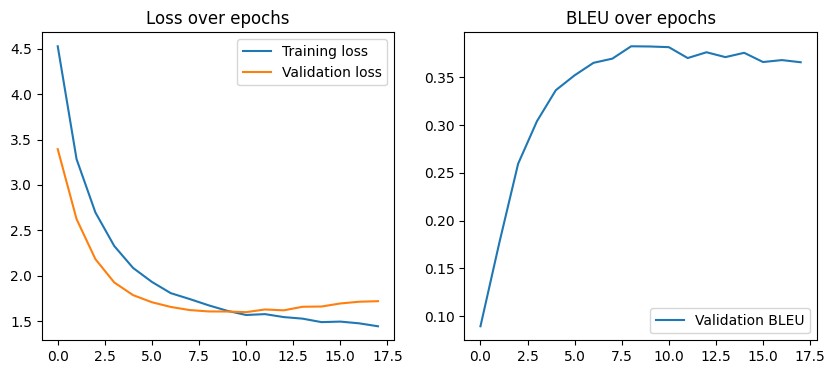

In [21]:
from utils.train_utils import save_artifacts, show_graph

save_artifacts(scaled_model, train_losses, val_losses, val_bleu_scores, teacher_forcing_ratios, batch_size, learning_rate, epochs, artifacts_path, model_path, max_grad_norm)
show_graph(train_losses, val_losses, val_bleu_scores, save_path=loss_graph_path, save=True)

In [22]:
test_dataset = load_dataset("bentrevett/multi30k", split="test")
test_dataset = test_dataset.map(
    lambda x: preprocess(x, "de", "en", de_vocab_to_index, en_vocab_to_index),
    batched=True,
    remove_columns=["en", "de"]
)
test_dataset.set_format(type="torch", columns=["source", "target"])

test_loader = DataLoader(test_dataset, batch_size=5, shuffle=True, collate_fn=collate_fn)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [23]:
from utils.train_utils import translate

test_batch = next(iter(test_loader))
translation_results = translate(scaled_model, test_batch, de_index_to_vocab, en_index_to_vocab, topk, device)

Source: <bos> eine frau spielt volleyball .
Pred: a woman is playing volleyball volleyball .
Target: <bos> a woman is playing volleyball .
----------------------------------------------------------------------------------------------------
Source: <bos> ein mann in einem anzug und mit hut spielt auf der straße gitarre .
Pred: a man a suit and hat playing guitar guitar on on the street
Target: <bos> a man in a suit and hat is playing the guitar on the street .
----------------------------------------------------------------------------------------------------
Source: <bos> ein mann und ein junge auf einem felsigen strand .
Pred: a man and boy on a on a rocky beach .
Target: <bos> a man and a boy on a rocky beach .
----------------------------------------------------------------------------------------------------
Source: <bos> ein ausblick auf eine <unk> mit einem mann in einer schwarzen schürze und weißen baseballmütze , der in der mitte des bildes steht .
Pred: a street worker a camer

Source: <bos> eine frau spielt volleyball .
Pred: a woman is playing volleyball volleyball .
Target: <bos> a woman is playing volleyball .


/content/deeplearning-practice/attentions/luong-attention/utils/train_utils.py:183: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([""] + sentence, rotation=90)
/content/deeplearning-practice/attentions/luong-attention/utils/train_utils.py:184: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([""] + translation)


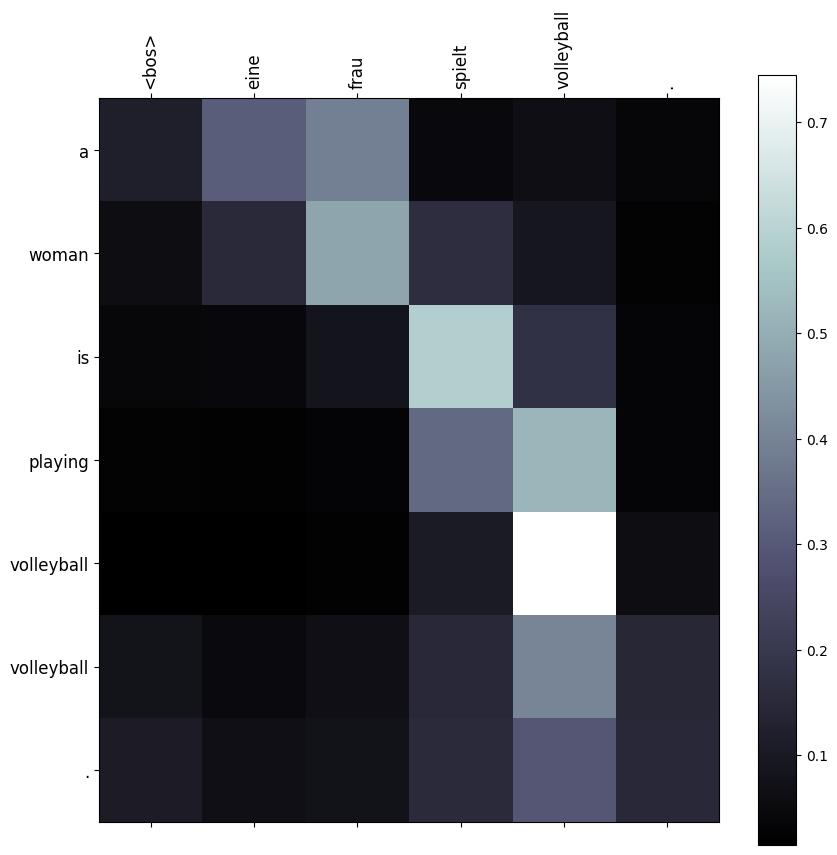

In [24]:
from utils.train_utils import display_attention

one_translation = translation_results[0]
print(f"Source: {" ".join(one_translation['source'])}")
print(f"Pred: {" ".join(one_translation['prediction'])}")
print(f"Target: {" ".join(one_translation['target'])}")

display_attention(one_translation['source'], one_translation['prediction'], one_translation['attention_weights'][:len(one_translation['prediction']), :len(one_translation['source'])])

Source: <bos> eine frau tippt auf ihrem handy , umgeben von regenschirmen .
Pred: a woman is writing her cellphone surrounded by umbrellas
Target: <bos> a woman texts on her phone while surrounded by umbrellas .


/content/deeplearning-practice/attentions/luong-attention/utils/train_utils.py:183: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([""] + sentence, rotation=90)
/content/deeplearning-practice/attentions/luong-attention/utils/train_utils.py:184: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([""] + translation)


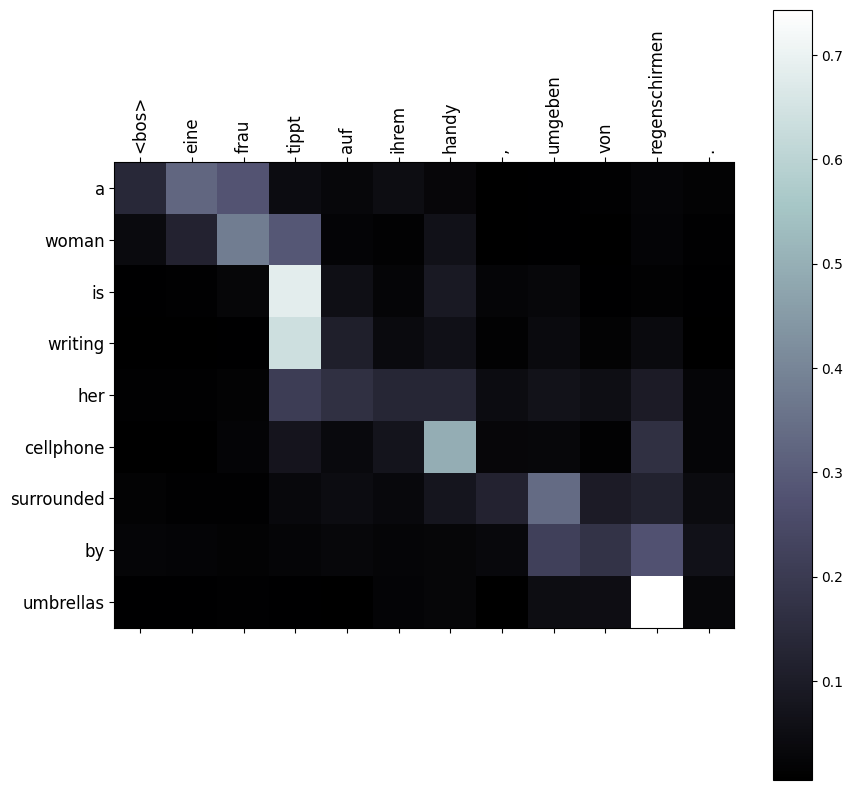

In [25]:
one_translation = translation_results[4]
print(f"Source: {" ".join(one_translation['source'])}")
print(f"Pred: {" ".join(one_translation['prediction'])}")
print(f"Target: {" ".join(one_translation['target'])}")

display_attention(one_translation['source'], one_translation['prediction'], one_translation['attention_weights'][:len(one_translation['prediction']), :len(one_translation['source'])])

In [26]:
test_dataset = load_dataset("bentrevett/multi30k", split="test")
test_dataset = test_dataset.map(
    lambda x: preprocess(x, "de", "en", de_vocab_to_index, en_vocab_to_index),
    batched=True,
    remove_columns=["en", "de"]
)
test_dataset.set_format(type="torch", columns=["source", "target"])

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

test_bleu_score = validate_with_bleu_score(scaled_model, test_loader, en_index_to_vocab, device)

print(f"Test BLEU Score: {test_bleu_score*100:.2f}")

Test BLEU Score: 36.20
